In [1]:
# パッケージのimport
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# DataSetを作成

In [3]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # データオーギュメンテーション
                transforms.RandomHorizontalFlip(),  # データオーギュメンテーション
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)


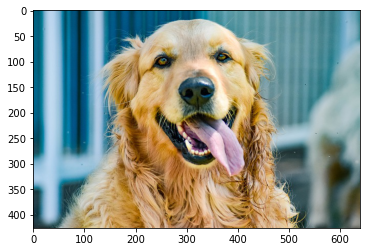

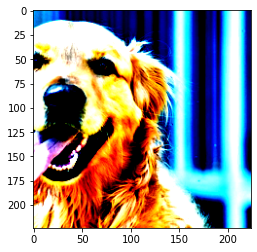

In [4]:
# 訓練時の画像前処理の動作を確認
# 実行するたびに処理結果の画像が変わる

# 1. 画像読み込み
image_file_path = '../00_base_notebook/data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)   # [高さ][幅][色RGB]

# 2. 元の画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理と処理済み画像の表示
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()


In [5]:
# アリとハチの画像へのファイルパスのリストを作成する


def make_datapath_list(phase="train"):
    """
    データのパスを格納したリストを作成する。

    Parameters
    ----------
    phase : 'train' or 'val'
        訓練データか検証データかを指定する

    Returns
    -------
    path_list : list
        データへのパスを格納したリスト
    """

    rootpath = "../data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)

    path_list = []  # ここに格納する

    # globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


# 実行
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

train_list


../data/hymenoptera_data/train/**/*.jpg
../data/hymenoptera_data/val/**/*.jpg


['../data/hymenoptera_data/train/ants/0013035.jpg',
 '../data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg',
 '../data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg',
 '../data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg',
 '../data/hymenoptera_data/train/ants/116570827_e9c126745d.jpg',
 '../data/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg',
 '../data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg',
 '../data/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg',
 '../data/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg',
 '../data/hymenoptera_data/train/ants/132478121_2a430adea2.jpg',
 '../data/hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg',
 '../data/hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg',
 '../data/hymenoptera_data/train/ants/1473187633_63ccaacea6.jpg',
 '../data/hymenoptera_data/train/ants/148715752_302c84f5a4.jpg',
 '../data/hymenoptera_data/train/ants/1489674356_09d48dde0a.jpg',
 '../data/hymenoptera_data/

In [6]:
# アリとハチの画像のDatasetを作成する


class HymenopteraDataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベルをファイル名から抜き出す
        if self.phase == "train":
            if "ants" in img_path:
                label = 0
            elif "bees" in img_path:
                label = 1
        elif self.phase == "val":
            if "ants" in img_path:
                label = 0
            elif "bees" in img_path:
                label = 1

        return img_transformed, label


# 実行
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 224, 224])
0


# DataLoaderを作成

In [7]:
# ミニバッチのサイズを指定
batch_size = 32

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(
    batch_iterator)  # 1番目の要素を取り出す
print(inputs.size())
print(labels)


torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 0])


# ネットワークモデルの作成する

In [8]:
# 学習済みのVGG-16モデルをロード
# VGG-16モデルのインスタンスを生成
use_pretrained = True  # 学習済みのパラメータを使用
net = models.vgg16(pretrained=use_pretrained)

# VGG16の最後の出力層の出力ユニットをアリとハチの2つに付け替える
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 訓練モードに設定
net.train()

print('ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました')


ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました


# 損失関数を定義

In [9]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# 最適化手法を設定

In [10]:
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 学習させるパラメータ名
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_updateの中身を確認
print("-----------")
print(params_to_update)


classifier.6.weight
classifier.6.bias
-----------
[Parameter containing:
tensor([[-0.0133, -0.0051, -0.0067,  ...,  0.0068, -0.0040,  0.0070],
        [ 0.0063, -0.0014,  0.0149,  ..., -0.0018, -0.0116, -0.0079]],
       requires_grad=True), Parameter containing:
tensor([-0.0020, -0.0065], requires_grad=True)]


In [11]:
# 最適化手法の設定
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)


# 学習・検証を実施

In [12]:
import mlflow
from azureml.core import Workspace

#subscription_id = '<SUBSCRIPTION_ID>'
#resource_group = '<RESOURCE_GROUP>'
#workspace = '<AML_WORKSPACE_NAME>'
subscription_id = "5290deef-ab3d-4e26-90bb-2296ecd99c71"
resource_group = "ml-handson"
workspace =  "ml-workspace"

ws = Workspace(workspace_name=workspace, subscription_id=subscription_id, resource_group=resource_group)

mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

In [13]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, torch.tensor(labels))  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)


            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            mlflow.log_metric(phase + "_loss" ,epoch_loss, step=epoch)
            mlflow.log_metric(phase + "_acc" ,epoch_acc, step=epoch)


In [14]:
experiment_name = "transfer_learning_notebook"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='', experiment_id='22d9b53c-decb-4293-b237-4394164773df', lifecycle_stage='active', name='transfer_learning_notebook', tags={}>

In [15]:
run = mlflow.start_run()

In [16]:
# 学習・検証を実行する
num_epochs=5
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/5
-------------


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 0/5 [00:00<?, ?it/s]/

val Loss: 0.7191 Acc: 0.4967
Epoch 2/5
-------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:32<00:00,  4.09s/it]


train Loss: 0.4691 Acc: 0.7325


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.06s/it]


val Loss: 0.1726 Acc: 0.9608
Epoch 3/5
-------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:34<00:00,  4.25s/it]


train Loss: 0.1429 Acc: 0.9588


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.33s/it]


val Loss: 0.1289 Acc: 0.9542
Epoch 4/5
-------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:32<00:00,  4.11s/it]


train Loss: 0.0810 Acc: 0.9753


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.99s/it]


val Loss: 0.1220 Acc: 0.9542
Epoch 5/5
-------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:32<00:00,  4.05s/it]


train Loss: 0.0843 Acc: 0.9671


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.12s/it]


val Loss: 0.1146 Acc: 0.9542


In [17]:
model_name = 'model.pth'
local_path = f'./{model_name}'
torch.save(net.state_dict(), local_path)

In [18]:
mlflow.log_artifact(local_path, "output/")

In [19]:
run_id = run.info.run_id
mlflow.register_model(model_uri = f'runs:/{run_id}/output/{model_name}', name = "transfer_learning_model")

Registered model 'transfer_learning_model' already exists. Creating a new version of this model...
2022/09/08 04:03:56 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: transfer_learning_model, version 1
Created version '1' of model 'transfer_learning_model'.


<ModelVersion: creation_timestamp=1662609836900, current_stage='None', description='', last_updated_timestamp=1662609836900, name='transfer_learning_model', run_id='925a6693-febb-44c6-8746-2eed211e7a14', run_link='', source='azureml://experiments/transfer_learning_notebook/runs/925a6693-febb-44c6-8746-2eed211e7a14/artifacts/output/model.pth', status='READY', status_message='', tags={}, user_id='', version='1'>

In [20]:
mlflow.end_run()

In [21]:
# PyTorchのネットワークパラメータのロード
net = models.vgg16()

# VGG16の最後の出力層の出力ユニットをアリとハチの2つに付け替える
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

load_path = './model.pth'

load_weights = torch.load(load_path)
net.load_state_dict(load_weights)

<All keys matched successfully>

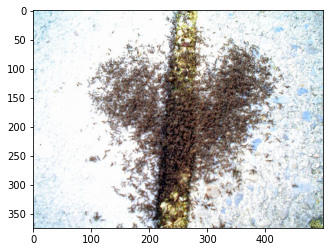

torch.Size([1, 3, 224, 224])


In [22]:
image_file_path = '../data/hymenoptera_data/val/ants/10308379_1b6c72e180.jpg'
img = Image.open(image_file_path)   # [高さ][幅][色RGB]

plt.imshow(img)
plt.show()

# 3. 画像の前処理と処理済み画像の表示
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="val")  # torch.Size([3, 224, 224])
img_transformed = img_transformed.view(1, 3, 224, 224)  # torch.Size([1, 3, 224, 224])
print(img_transformed.size())

In [23]:
outputs = net(img_transformed)
_, preds = torch.max(outputs, 1)
num_pred = int(preds[0])

if num_pred == 0:
    cate_pred = "ants"
elif num_pred == 1:
    cate_pred = "bees"

print(outputs)
print(cate_pred)

tensor([[ 1.4314, -0.6511]], grad_fn=<AddmmBackward0>)
ants


以上